# COMP90051 Project 2

In [192]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [193]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [194]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q = np.full(narms, Q0)
        self.Q_counts = np.zeros(narms, dtype=np.int64)
        self.Q_totals = np.zeros(narms)
        
        
    def play(self, tround, context=None):
        exploit = np.random.choice(np.argwhere(self.Q == self.Q.max()).flatten())
        explore = np.random.randint(self.narms)
        if np.random.random_sample() <= self.epsilon:
            return explore
        else:
            return exploit
        
        
    def update(self, arm, reward, context=None):
        self.Q_totals[arm-1] += reward
        self.Q_counts[arm-1] += 1
        
        for i in range(self.narms):
            if self.Q_counts[i] > 0:
                self.Q = self.Q_totals[i] / self.Q_counts[i]


In [195]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q = np.full(narms, Q0)
        self.Q_counts = np.zeros(narms, dtype=np.int64)
        self.Q_totals = np.zeros(narms)
        self.tround = 1
        
    
    def play(self, tround, context=None):
        self.tround = tround
        arm = np.random.choice(np.argwhere(self.Q == self.Q.max()).flatten())
        return arm
        
        
    def update(self, arm, reward, context=None):
        self.Q_totals[arm-1] += reward
        self.Q_counts[arm-1] += 1
        for i in range(self.narms):
            if self.Q_counts[i] > 0:
                self.Q[i] = (self.Q_totals[i] / self.Q_counts[i]) + np.sqrt((self.rho*np.log(self.tround+1)) / self.Q_totals[i])
        

## 2. The Basic Thompson Bandit

In [196]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.S = np.full(narms, 0)
        self.F = np.full(narms, 0)
        self.thetas = np.array([np.random.beta(alpha0, beta0) for _ in range(narms)])
        
        
    def play(self, tround, context=None):
        arm = np.argmax(self.thetas)
        return arm
        
        
    def update(self, arm, reward, context=None):
        if reward == 1:
            self.S[arm-1] += 1
        else:
            self.F[arm-1] += 1
        self.thetas[arm-1] = np.random.beta(self.alpha0+self.S[arm-1], self.beta0+self.F[arm-1])


## 3. Off-Policy Evaluation

In [197]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    T = arms.shape[0]
    R = []
    tround = 1
    for i in range(T):
        arm = arms[i]
        reward = rewards[i]
        context = contexts[i]
        if mab.play(tround, context) == arm:
            R.append(reward)
            mab.update(arm, reward, context)
            if nrounds is not None and tround >= nrounds:
                break
            else:
                tround += 1
            
    return np.array(R)
    

In [198]:
data = []
with open('dataset.txt') as f:
    for row in f:
        data.append(list(map(int, row.split())))
        
data = np.array(data)
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

print(data.shape)
print(arms.shape)
print(rewards.shape)
print(contexts.shape)

(10000, 102)
(10000,)
(10000,)
(10000, 100)


In [92]:
import pandas as pd
pd.Series(rewards).value_counts()

0    8961
1    1039
dtype: int64

In [199]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.06


In [16]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16814159292


C:\Users\Allan\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.0575


C:\Users\Allan\Anaconda3\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(10, 0) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


## 4. Contextual Bandits - LinUCB

In [88]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A = [np.identity(ndims) for _ in range(narms)]
        self.b = [np.zeros(ndims).reshape(ndims, 1) for _ in range(narms)]
        
        
    def play(self, tround, context):
        theta = [np.dot(inv(self.A[i]), self.b[i]) for i in range(self.narms)]  

        p = []
        for i in range(self.narms):
            x_i = context[i*self.ndims: (i+1)*self.ndims].reshape(self.ndims, 1)
            #print("Context vector for arm shape:", x_i.shape)
            #print("Param (theta) for arm shape :", theta[i].T.shape)
            #print(np.dot(theta[i].T, x_i))
            #print(self.alpha*np.sqrt(x_i.T @ inv(self.A[i]) @ x_i))
            #print(np.dot(theta[i].T, x_i) + self.alpha*np.sqrt(x_i.T @ inv(self.A[i]) @ x_i))

            p.append(np.dot(theta[i].T, x_i) + self.alpha*np.sqrt(x_i.T @ inv(self.A[i]) @ x_i))
        p = np.array(p)
        return np.argmax(p)
                          
        
    def update(self, arm, reward, context):
        x_i = context[(arm-1)*self.ndims: arm*self.ndims].reshape(self.ndims, 1)
        if reward != 0:
            print("yeet")
        #print(x_i.shape)
        #print(x_i.T.shape)
        #print(np.dot(x_i, x_i.T).shape)
        #print(np.dot(x_i, x_i.T))
        
        #print(x_i.shape)
        #print(x_i.T.shape)
        
        self.A[arm-1] += np.dot(x_i, x_i.T)
        self.b[arm-1] += reward*x_i
        
    

In [89]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print(results_LinUCB) # comment this line out later
print('LinUCB average reward', np.mean(results_LinUCB))

800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

## 5. Contextual Bandits - LinThompson

In [141]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms = narms
        self.ndims = ndims
        self.v = v
        self.B = np.identity(ndims)
        self.mu = np.zeros(ndims).reshape(-1,1)
        self.f = np.zeros(ndims).reshape(-1,1)
        
        
    def play(self, tround, context):
        mu_tround = np.random.multivariate_normal(self.mu.flatten(), self.v**2*inv(self.B))
        b = np.array([context[i*self.ndims: (i+1)*self.ndims] for i in range(self.narms)])
        lc = np.array([np.dot(b[i], mu_tround) for i in range(self.narms)])
        return np.argmax(lc)
        
    
    def update(self, arm, reward, context):
        b_arm = context[(arm-1)*self.ndims: arm*self.ndims].reshape(-1,1)
        self.B += np.dot(b_arm, b_arm.T)
        self.f += b_arm*reward
        self.mu = np.dot(inv(self.B), self.f)


In [138]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

800
LinThompson average reward 0.02125


## 6. Evaluation
### 6.A.

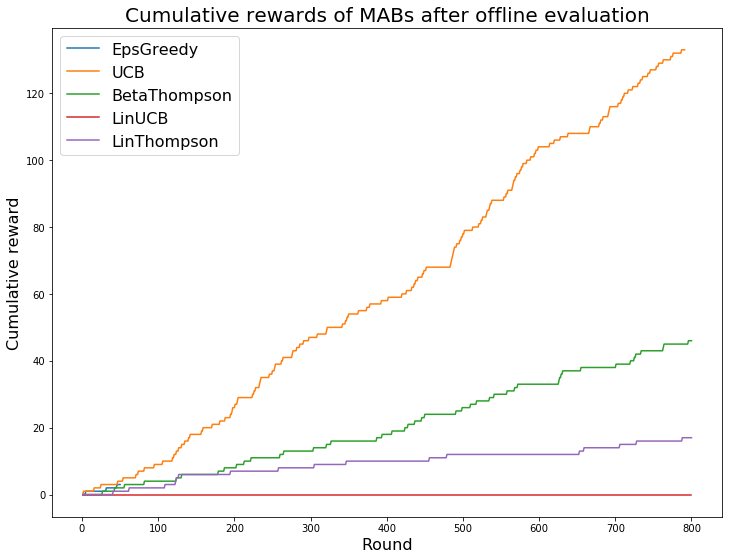

In [213]:
%matplotlib inline
plt.figure(figsize=(12,9))
plt.title('Cumulative rewards of MABs after offline evaluation', fontsize=20)
plt.xlabel('Round', fontsize=16)
plt.ylabel('Cumulative reward', fontsize=16)

mab_results = [results_EpsGreedy, results_UCB, results_BetaThompson, results_LinUCB, results_LinThompson]
for results in mab_results:
    trounds = np.arange(1, len(results)+1)
    cumulative_results = np.cumsum(results)
    plt.plot(trounds, cumulative_results)
    
"""
plt.plot(x, x)
plt.plot(x, 2*x)
plt.plot(x, 3*x)
plt.plot(x, 4*x)
plt.plot(x, 5*x)
plt.plot(np.arange(400), np.full(400, 3000))
"""

plt.legend(['EpsGreedy', 'UCB', 'BetaThompson', 'LinUCB', 'LinThompson'], fontsize=16)
plt.show()
plt.clf()

### 6.B.

In [154]:
s = [results_EpsGreedy, results_UCB, results_BetaThompson, results_LinUCB, results_LinThompson]
for i in s:
    print(len(i))

53
791
800
800
800


In [158]:
y[:50]

array([   1,    4,    9,   16,   25,   36,   49,   64,   81,  100,  121,
        144,  169,  196,  225,  256,  289,  324,  361,  400,  441,  484,
        529,  576,  625,  676,  729,  784,  841,  900,  961, 1024, 1089,
       1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936,
       2025, 2116, 2209, 2304, 2401, 2500])